## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:
## Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, paremeters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```
## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

## [Hint: If you are wondering how to use the "dense layer representative of an image" in step 2, see this exercise that extracts a [1,2048] dense representattive from an image using the InceptionV3 pre-trained model.]
https://colab.research.google.com/drive/14-6qRGARgBSj4isZk86zKQtyIT2f9Wu1#scrollTo=_IqraxtP4Ex3


## Good Luck!

#Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images.

In [1]:
#Load libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import resnet
#resnet50 = resnet.ResNet50
#from keras.applications.resnet import preprocess_input



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/FourthBrainMLE/week_8

/content/drive/MyDrive/FourthBrainMLE/week_8


In [ ]:
#!unzip Data.zip

In [4]:
train_csv_data = pd.read_csv("./Data/train/train.csv")
train_csv_data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [5]:
train_csv_data.shape

(3435, 8)

#Analyzing the distribution of 0 and 1 labels for each class category

In [6]:
for label in train_csv_data.columns[1:]:
  print('Distribution of 0 and 1 in the class:', label)
  print(train_csv_data[label].value_counts())
  print('')

Distribution of 0 and 1 in the class: opacity
0    1902
1    1533
Name: opacity, dtype: int64

Distribution of 0 and 1 in the class: diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64

Distribution of 0 and 1 in the class: glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64

Distribution of 0 and 1 in the class: macular edema
0    2919
1     516
Name: macular edema, dtype: int64

Distribution of 0 and 1 in the class: macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64

Distribution of 0 and 1 in the class: retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64

Distribution of 0 and 1 in the class: normal
0    2910
1     525
Name: normal, dtype: int64



####It can be observe that for each class the total number of 'label 0' is much higher than the 'label 1'.

####Total number of images with single or multiple class categories (i.e. multiple pathologies).

In [7]:
labels = train_csv_data.columns[1:]
def multiple_labels(row):
  return ",".join([labels[i] for i, value in enumerate(row[1:]) if value == 1])

train_csv_data.apply(lambda x: multiple_labels(x), axis=1).value_counts()


opacity                                                                  671
normal                                                                   525
glaucoma                                                                 327
macular degeneration                                                     299
diabetic retinopathy                                                     212
opacity,macular degeneration                                             212
opacity,diabetic retinopathy                                             186
retinal vascular occlusion                                               170
diabetic retinopathy,macular edema                                       162
opacity,diabetic retinopathy,macular edema                               154
opacity,glaucoma                                                         140
macular edema,retinal vascular occlusion                                  74
opacity,macular edema,retinal vascular occlusion                          62

#### It can be seen that higher number of images labeled with opacity, normal, glaucoma, macular degeneration class categories. The rest of the images are labeled with multiple class actegories. The class distribution clearly indicates that image data set is highly imbalance. 

## Extracting diabetic retinopathy, glaucoma, normal class categories

In [8]:
#Images label extraction for normal, diabetic retinopathy, glaucoma class categories
normal_label = np.array(train_csv_data.index[(train_csv_data['normal'] == 1)])
diabetic_retinopathy_label = np.array(train_csv_data.index[(train_csv_data['diabetic retinopathy'] == 1)])
glaucoma_label = np.array(train_csv_data.index[(train_csv_data['glaucoma'] == 1)])
array_label = np.concatenate((np.concatenate((diabetic_retinopathy_label, glaucoma_label)), normal_label))
image_labels = np.array(train_csv_data.loc[array_label,['filename']])
data_labels = np.array(train_csv_data.loc[array_label, ['diabetic retinopathy', 'glaucoma', 'normal']])
#data_labels = train_csv_data.loc[array_label, ['diabetic retinopathy', 'glaucoma', 'normal']].to_numpy()

In [9]:
image_labels

array([['10ee8c8a72b4.jpg'],
       ['3b6da0297f92.jpg'],
       ['677c30357c4e.jpg'],
       ...,
       ['2477323c9434.jpg'],
       ['0a1ca36be2c5.jpg'],
       ['96f11f20fe93.jpg']], dtype=object)

In [10]:
data_labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [11]:
image_labels.shape

(1877, 1)

In [12]:
data_labels.shape

(1877, 3)

In [13]:
train_path = './Data/train/train/'

In [14]:
from tqdm import tqdm
from keras.preprocessing import image

train_images = []
for i in tqdm(range(image_labels.shape[0])):
    img = image.load_img(train_path+image_labels[i][0], target_size=(256,256,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)

X = np.array(train_images)

100%|██████████| 1877/1877 [08:23<00:00,  3.73it/s]


In [15]:
X.shape

(1877, 256, 256, 3)

In [16]:
y = data_labels
y.shape

(1877, 3)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

print(f'X_train_shape {X_train.shape}, X_test_shape {X_test.shape}, y_train_shape {y_train.shape}, y_test_shape {y_test.shape}')

X_train_shape (1313, 256, 256, 3), X_test_shape (564, 256, 256, 3), y_train_shape (1313, 3), y_test_shape (564, 3)


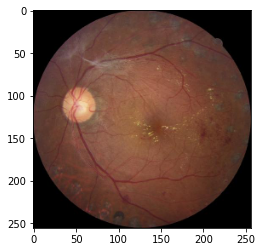

Image Class: [1 0 0]
Maximum pixel value in an image = 1.0


In [18]:
#display sample training image
index = 110
plt.imshow(X_train[index])
plt.show()
print(f"Image Class: {y_train[index]}")
print(f"Maximum pixel value in an image = {np.max(X_train[index])}")

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# create the base pre-trained model
base_model = InceptionV3(include_top=False, weights='imagenet')

#Add a global spatial average pooling layer
out_layer = base_model.output
out_layer = GlobalAveragePooling2D()(out_layer)

#Add a fully-connected layer
out_layer = Dense(512, activation='relu')(out_layer)
out_layer = BatchNormalization()(out_layer)
out_layer = Dropout(0.5)(out_layer)
# add a logistic layer of 3 classes
final_outputs = Dense(3, activation='softmax')(out_layer)
#final_outputs = Dense(3, activation='sigmoid')(out_layer)

# this is the model we will train
inception_model = Model(inputs=base_model.input, outputs=final_outputs)
print('Total no.of Layers1:', len(inception_model.layers))

base_model.trainable = False

# Fine tune the model
inception_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 249
# Freeze all the layers before the `fine_tune_at` layer
for layer in inception_model.layers[:fine_tune_at]:
    layer.trainable = False

# Optimizers with learning rate
#adam = Adam(learning_rate=0.0001)
sgd = SGD(learning_rate=0.0001, momentum=0.9)
inception_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

inception_model.summary()


87924736/87910968 [==============================] - 1s 0us/step
Total no.of Layers1: 316
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 ali

In [20]:
# Train the model alongside the top Dense layers
Inception_model_history = inception_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
42/42 [==============================] - 21s 156ms/step - loss: 1.3611 - accuracy: 0.4836 - val_loss: 0.9917 - val_accuracy: 0.4486
Epoch 2/10
42/42 [==============================] - 4s 97ms/step - loss: 0.6893 - accuracy: 0.7388 - val_loss: 0.8451 - val_accuracy: 0.5975
Epoch 3/10
42/42 [==============================] - 4s 97ms/step - loss: 0.4871 - accuracy: 0.8165 - val_loss: 0.7205 - val_accuracy: 0.6968
Epoch 4/10
42/42 [==============================] - 4s 97ms/step - loss: 0.4026 - accuracy: 0.8492 - val_loss: 0.6158 - val_accuracy: 0.7535
Epoch 5/10
42/42 [==============================] - 4s 98ms/step - loss: 0.3668 - accuracy: 0.8599 - val_loss: 0.5449 - val_accuracy: 0.7855
Epoch 6/10
42/42 [==============================] - 4s 98ms/step - loss: 0.2633 - accuracy: 0.9056 - val_loss: 0.4968 - val_accuracy: 0.8050
Epoch 7/10
42/42 [==============================] - 4s 103ms/step - loss: 0.2144 - accuracy: 0.9337 - val_loss: 0.4675 - val_accuracy: 0.8227
Epoch 8/10

In [21]:
#Plotting the model Accurcay and Loss
def Plot_History(fit_history):
  acc = [0.] + fit_history.history['accuracy']
  val_acc = [0.] + fit_history.history['val_accuracy']

  loss = fit_history.history['loss']
  val_loss = fit_history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('Eepoch')
  plt.show()

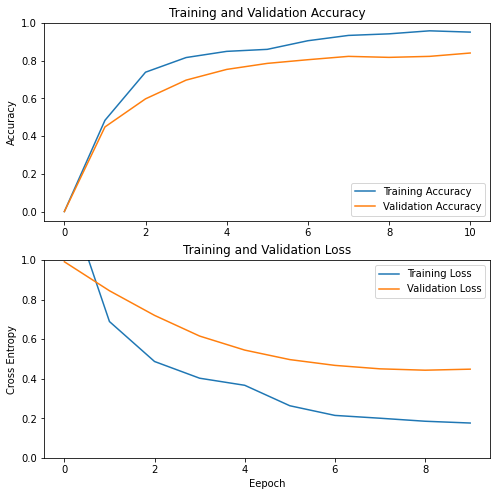

                      precision    recall  f1-score   support

diabetic retinopathy       0.82      0.88      0.85       231
            glaucoma       0.79      0.70      0.74       165
              normal       0.92      0.92      0.92       168

            accuracy                           0.84       564
           macro avg       0.84      0.83      0.84       564
        weighted avg       0.84      0.84      0.84       564



In [22]:
Plot_History(Inception_model_history)
pred = inception_model.predict(X_test, batch_size=32)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=['diabetic retinopathy', 'glaucoma', 'normal']))

#Task 2: Visualize the heatmap/saliency/features
References:
1. https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
2. https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48
3. https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353
4. https://www.kaggle.com/asraf047/grad-cam-cnn

In [23]:
#The Grad-CAM algorithm
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications.inception_v3 import preprocess_input

def gradCAM(orig, model, layer_info, shape = 6, intensity=0.5, resize=256):
  img = image.load_img(orig, target_size=(256,256,1), grayscale=False)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  
  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer(layer_info)
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = np.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((shape, shape))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (resize, resize)))
  cv2_imshow(cv2.resize(img, (resize, resize)))


Diabetic Retinopathy image: ./Data/train/train/c425934a1d53.jpg Glaucoma image: ./Data/train/train/ec5c720380b2.jpg


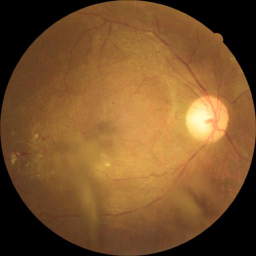

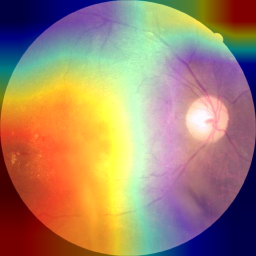

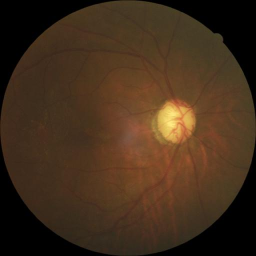

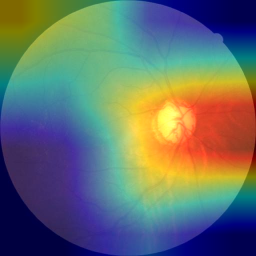

In [24]:
#Gradient-weighted Class Activation Mapping (Grad-CAM) heatmap visualization
dia_ret_image_rand = np.random.randint(0, len(diabetic_retinopathy_label))
dia_ret_image_path = train_path + train_csv_data.iloc[diabetic_retinopathy_label[dia_ret_image_rand], 0]

glau_image_rand = np.random.randint(0, len(glaucoma_label))
glau_image_path = train_path + train_csv_data.iloc[glaucoma_label[glau_image_rand], 0]

print(f'Diabetic Retinopathy image: {dia_ret_image_path} Glaucoma image: {glau_image_path}')

gradCAM(dia_ret_image_path, inception_model, 'conv2d_93')
gradCAM(glau_image_path, inception_model, 'conv2d_93')

#### From the final convolution layer, grad_CAM is showing the heatmaps of arbitraryly selected images of 'diabetic retinopathya' and 'galucoma' class labels. We can visually verify that where the CNN is looking in the images.  

#Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.

In [25]:
import glob
test_path = "./Data/test/test"
unlabeled_test_images = glob.glob(test_path + '/*.jpg')
print(len(unlabeled_test_images))


350


In [26]:
test_images = []
for i in tqdm(range(len(unlabeled_test_images))):
  img = image.load_img(unlabeled_test_images[i], target_size=(256, 256, 1), grayscale=False)
  img = image.img_to_array(img)
  img = img/255
  test_images.append(img)

test_images = np.array(test_images)

100%|██████████| 350/350 [00:04<00:00, 73.92it/s] 


In [27]:
test_images.shape

(350, 256, 256, 3)

file_name = ./Data/test/test/07e4191fa3a8.jpg


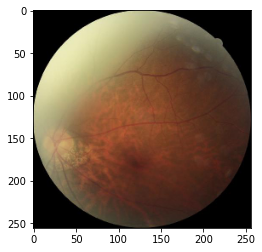

In [28]:
print('file_name =', unlabeled_test_images[10])
plt.imshow(test_images[10])
plt.show()

In [29]:
init_test_images_labels = np.zeros((test_images.shape[0], 3)) #for 3 classes

In [30]:
init_test_images_labels.shape

(350, 3)

In [31]:
X_unlabeled_dense = list()
Y_unlabeled_predict = list()
for i in range(np.shape(test_images)[0]):
  img = test_images[i]
  img = np.expand_dims(img, axis=0)
  result = inception_model.predict(img)
  X_unlabeled_dense.append(result)
  label = np.argmax(inception_model.predict(img))
  Y_unlabeled_predict.append(label)

print("X_unlabeled_dense:", X_unlabeled_dense)
print("Total:", len(X_unlabeled_dense))
print(" ")
print("Y_unlabeled_predict:", Y_unlabeled_predict)
print("Total:", len(Y_unlabeled_predict))

X_unlabeled_dense: [array([[0.7150556 , 0.1577048 , 0.12723961]], dtype=float32), array([[0.77266663, 0.11730018, 0.11003315]], dtype=float32), array([[0.7589054 , 0.20282412, 0.03827051]], dtype=float32), array([[0.01607148, 0.5216418 , 0.4622867 ]], dtype=float32), array([[0.89705837, 0.09993537, 0.0030062 ]], dtype=float32), array([[0.91385555, 0.076594  , 0.0095504 ]], dtype=float32), array([[0.9959268 , 0.00220669, 0.00186644]], dtype=float32), array([[0.98336524, 0.00738341, 0.00925137]], dtype=float32), array([[0.85494506, 0.14135183, 0.00370304]], dtype=float32), array([[0.26329866, 0.73549074, 0.00121054]], dtype=float32), array([[0.52841735, 0.34654102, 0.12504163]], dtype=float32), array([[0.933964  , 0.06446644, 0.00156947]], dtype=float32), array([[0.9940274 , 0.00264042, 0.00333218]], dtype=float32), array([[0.96477103, 0.0131167 , 0.02211224]], dtype=float32), array([[0.86550486, 0.13009366, 0.00440145]], dtype=float32), array([[0.6934805 , 0.04340747, 0.263112  ]], dtyp

In [32]:
from tensorflow.python.keras.backend import one_hot
onehot_encoded_unlabled = one_hot(Y_unlabeled_predict, 3)

In [33]:
onehot_encoded_unlabled

<tf.Tensor: shape=(350, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)>

In [34]:
onehot_encoded_unlabled.shape

TensorShape([350, 3])

In [35]:
X_total_images = np.concatenate((X, test_images))
Y_total_labels = np.concatenate((y, onehot_encoded_unlabled))
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X_total_images, Y_total_labels, random_state=42, test_size=0.3)
print(f'X_train_total_shape {X_train_total.shape}, X_test_total_shape {X_test_total.shape}, y_train_total_shape {y_train_total.shape}, y_test_total_shape {y_test_total.shape}')

X_train_total_shape (1558, 256, 256, 3), X_test_total_shape (669, 256, 256, 3), y_train_total_shape (1558, 3), y_test_total_shape (669, 3)


In [36]:
Inception_model_history_total = inception_model.fit(X_train_total, y_train_total, batch_size=32, epochs=10, validation_data=(X_test_total, y_test_total), verbose=1)

Epoch 1/10
49/49 [==============================] - 11s 152ms/step - loss: 0.2752 - accuracy: 0.9146 - val_loss: 0.2621 - val_accuracy: 0.9133
Epoch 2/10
49/49 [==============================] - 5s 99ms/step - loss: 0.2215 - accuracy: 0.9288 - val_loss: 0.2595 - val_accuracy: 0.9193
Epoch 3/10
49/49 [==============================] - 5s 100ms/step - loss: 0.1754 - accuracy: 0.9487 - val_loss: 0.2571 - val_accuracy: 0.9118
Epoch 4/10
49/49 [==============================] - 5s 99ms/step - loss: 0.1598 - accuracy: 0.9596 - val_loss: 0.2516 - val_accuracy: 0.9088
Epoch 5/10
49/49 [==============================] - 5s 99ms/step - loss: 0.1533 - accuracy: 0.9499 - val_loss: 0.2567 - val_accuracy: 0.9103
Epoch 6/10
49/49 [==============================] - 5s 99ms/step - loss: 0.1382 - accuracy: 0.9685 - val_loss: 0.2625 - val_accuracy: 0.9073
Epoch 7/10
49/49 [==============================] - 5s 100ms/step - loss: 0.1405 - accuracy: 0.9685 - val_loss: 0.2642 - val_accuracy: 0.9103
Epoch 8/1

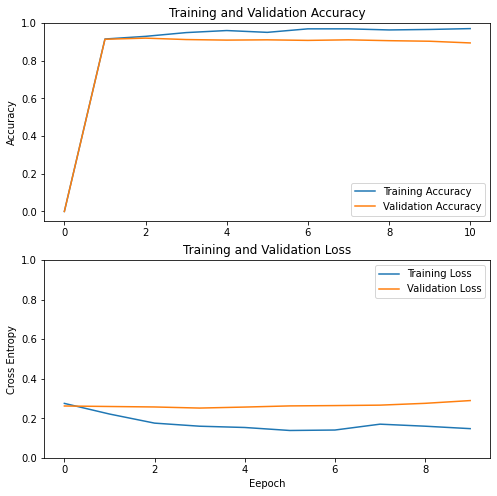

                      precision    recall  f1-score   support

diabetic retinopathy       0.90      0.89      0.90       290
            glaucoma       0.86      0.83      0.85       206
              normal       0.92      0.97      0.94       173

            accuracy                           0.89       669
           macro avg       0.89      0.90      0.90       669
        weighted avg       0.89      0.89      0.89       669



In [37]:
Plot_History(Inception_model_history_total)
pred_total = inception_model.predict(X_test_total, batch_size=32)
print(classification_report(np.argmax(y_test_total, axis=1), np.argmax(pred_total, axis=1), target_names=['diabetic retinopathy', 'glaucoma', 'normal']))

###Discussion: After including the predicted test imgages labeld data to the training images data, the model acuuracy, precision, recall, and f1-score increased considerably on the agumented data (total images data).

#Receiver Operating Characteristic (ROC)

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [43]:
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_total[:, i], pred_total[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_total.ravel(), pred_total.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

###Plot of a ROC curve for a specific class

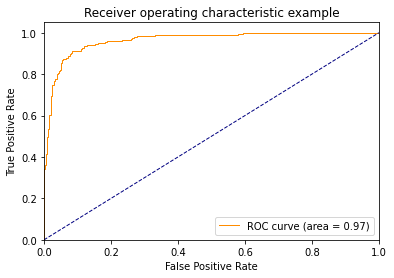

In [44]:
plt.figure()
lw = 1
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

###Plot ROC curves for the multiclass problem
#####Compute macro-average ROC curve and ROC area



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


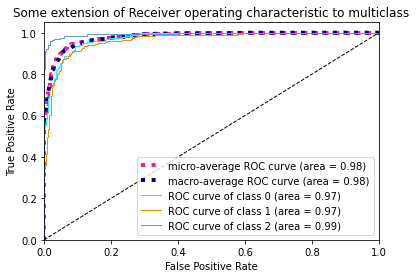

In [45]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()